## Data loading and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/kaggle/input/snapchat-reviews-daily-updated/snapchat_reviews.csv")

In [3]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,6d3484a5-f27c-40f7-bc4d-712e42da2b0a,Rapture Awaji001,Easy,5,0,NaN,2025-09-10 11:54:55,NaN
1,498b2247-8bdd-403b-8ead-4df244ad6d7a,FathimaFarhana,wow,5,0,13.39.0.45,2025-09-10 11:54:47,13.39.0.45
2,bf629c03-8a27-4905-ae31-360127e325b7,TY GIRL ON SHOW,it is slow that is y I didn't give it 5 stars,1,0,13.57.0.49,2025-09-10 11:54:31,13.57.0.49
3,b114eb0c-6fd9-4633-8151-04b4ca14b4fd,Raman Bepari,Worst app ever 😰🤮🤢🤮🤢🤢🤢,1,0,NaN,2025-09-10 11:53:39,NaN
4,b5c2206a-73b9-4e09-9fe3-8208a220cc26,Jabbar Khan,Nazia Khan g,5,0,NaN,2025-09-10 11:50:42,NaN


In [4]:
print(df.shape)
print(df.content.isna().sum())

(231984, 8)
3


In [5]:
df.dropna(axis=0,subset=['content'],inplace=True)

In [6]:
df[df.duplicated(subset=['userName', 'content', 'score'])].shape

(3053, 8)

In [7]:
df.drop_duplicates(subset=['userName', 'content', 'score'], inplace=True)
print(df.shape)

(228928, 8)


In [8]:
df.reset_index(drop=True, inplace=True)

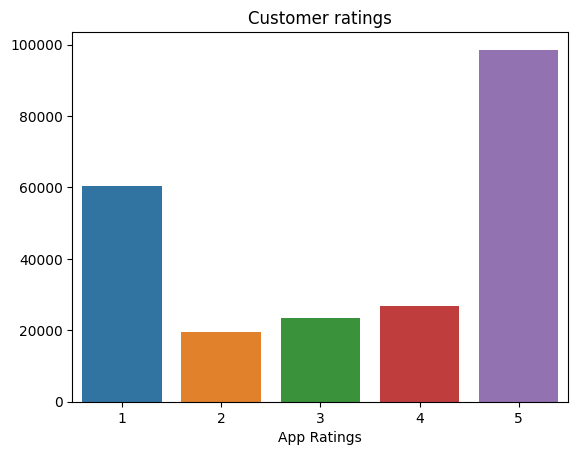

In [9]:
sns.countplot(x='score', data=df)
plt.title("Customer ratings")
plt.xlabel("App Ratings")
plt.ylabel("")
plt.show()

## Adding sentiment columns

#### Roberta trained model
- Use a model trained for a large set of data
- Transformer model accounts for the words but also the context related to the other words.

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import torch

In [11]:
# Setting the device to a GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Loading model and tokenizer
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()  # Set to evaluation mode

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-09-11 14:00:23.275941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757599223.446371      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757599223.487016      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [13]:
# Moving the model (or the DataParallel wrapper) to the GPUs
if torch.cuda.device_count() > 1:
  print(f"Let's use {torch.cuda.device_count()} GPUs!")
  model = torch.nn.DataParallel(model)

model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
# Function for sentiment columns
def batch_polarity_score_roberta(text_batch):
    try:
        # Tokenize the batch and set a max_length to prevent errors
        encoded_text = tokenizer(text_batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
        
        # Moving the input tensors to the GPU ***
        encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

        # Inference with no_grad
        with torch.no_grad():
            # Get model output (now runs on GPU)
            output = model(**encoded_text)
            # Get logits and move them back to CPU for numpy/softmax
            logits = output[0]
            scores = torch.softmax(logits, dim=-1).cpu().numpy()
        
        return [{'neg': s[0], 'neu': s[1], 'pos': s[2]} for s in scores]
        
    except Exception as e:
        print(f"Error processing batch: {e}")
        raise # Re-raise to expose issues

In [15]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx]
def custom_text_collate(batch):
    return batch
    
def create_dataloader(texts, batch_size=30):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_text_collate)
    return dataloader

def batch_polarity_score_roberta_dataloader(dataloader):
    all_scores = []
    for batch_text in tqdm(dataloader, desc="Analyzing Sentiment in Batches"):
        all_scores.extend(batch_polarity_score_roberta(batch_text))
    return all_scores

In [16]:
# Create DataLoader and get sentiment scores
dataloader = create_dataloader(df["content"].tolist(), batch_size=30)
roberta_sentiment_scores = batch_polarity_score_roberta_dataloader(dataloader)

# Convert to DataFrame
roberta_sentiment_df = pd.DataFrame(roberta_sentiment_scores)
df_sEntiment = pd.concat([df, roberta_sentiment_df], axis=1)


Analyzing Sentiment in Batches:   0%|          | 0/7631 [00:00<?, ?it/s]

## Testing the created sentiment column

In [17]:
df_sEntiment.isnull().sum()

reviewId                    0
userName                    0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    57285
at                          0
appVersion              57285
neg                         0
neu                         0
pos                         0
dtype: int64

In [18]:
print(df.shape)
print(df_sEntiment.shape)
print(df_sEntiment.info())

(228928, 8)
(228928, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228928 entries, 0 to 228927
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewId              228928 non-null  object 
 1   userName              228928 non-null  object 
 2   content               228928 non-null  object 
 3   score                 228928 non-null  int64  
 4   thumbsUpCount         228928 non-null  int64  
 5   reviewCreatedVersion  171643 non-null  object 
 6   at                    228928 non-null  object 
 7   appVersion            171643 non-null  object 
 8   neg                   228928 non-null  float32
 9   neu                   228928 non-null  float32
 10  pos                   228928 non-null  float32
dtypes: float32(3), int64(2), object(6)
memory usage: 16.6+ MB
None


<function matplotlib.pyplot.show(close=None, block=None)>

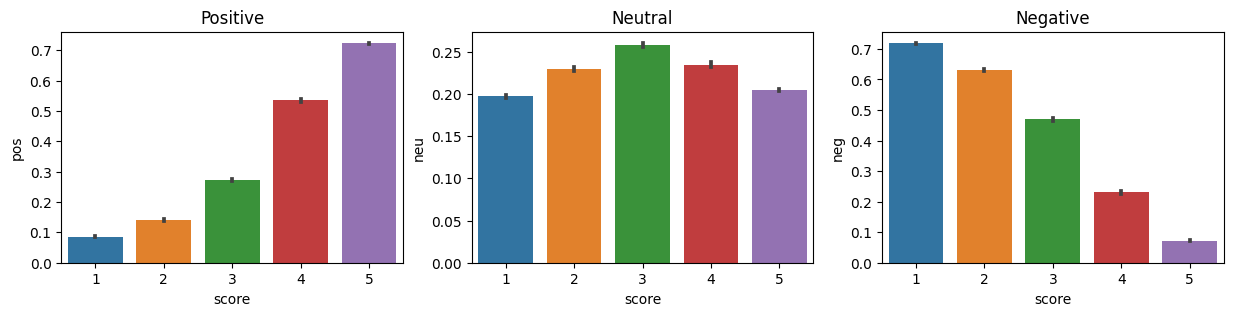

In [20]:
fig, ax = plt.subplots(1,3,figsize=(15,3))
sns.barplot(x='score', y='pos', data=df_sEntiment, ax=ax[0])
sns.barplot(x='score', y='neu', data=df_sEntiment, ax=ax[1])
sns.barplot(x='score', y='neg', data=df_sEntiment, ax=ax[2])
ax[0].set_title("Positive")
ax[1].set_title("Neutral")
ax[2].set_title("Negative")
plt.show

In [21]:
df_sEntiment.iloc[200:205]

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,neg,neu,pos
200,f50d1f1f-26ae-49ec-8b28-409332bbc3ec,My life,tenden,5,0,NaN,2025-09-09 11:13:27,NaN,0.236852,0.542366,0.220782
201,5b99a682-f4c6-4d2c-819f-83f69ed82626,Manoj Kumar,aacha laga hai,5,0,13.43.0.43,2025-09-09 11:13:09,13.43.0.43,0.238091,0.566821,0.195088
202,091c3358-2870-46ad-8c8a-caf5d729bb01,Kulwinder Kaur,video seving problem,1,0,NaN,2025-09-09 11:10:43,NaN,0.462899,0.507847,0.029253
203,7a7db0ae-f520-4028-9c9b-08a5a3f652a9,Manas Nayak,not complaining snapchat but it's 1 problem th...,3,0,13.57.0.49,2025-09-09 11:09:53,13.57.0.49,0.884450,0.102518,0.013032
204,c7a1c03c-95c2-496d-b33a-faf519b095df,Saqhib Pasha,secret,5,0,13.57.0.49,2025-09-09 11:09:02,13.57.0.49,0.212458,0.650655,0.136887


### Most Positive sentiment with 1 star review

In [22]:
df_sEntiment.query('score==1').sort_values('pos', ascending=False)['content'].values[0]

'Very good 😊🫶😊🫡😊🫶😊🫶😊😊☺️ you too I love you soooooooooooooooooooooo much 💕✨♥️😘😘♥️ video chat open ke the rishta your time with your 📿🤲'

### Most Negative sentiment with 5 star review

In [23]:
df_sEntiment.query('score==5').sort_values('neg', ascending=False)['content'].values[0]

"I hate this! It won't even let me install the thing! This is the worst app I have ever seen, heard of, or attempted to install! I hate this! Why? This is the worst app ever!! In the world!! That is the kindest way to put it!!!!"

### 5 High neutral sentiments

In [24]:
df_sEntiment.sort_values('neu', ascending=False).head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,neg,neu,pos
89516,edfa0780-116c-4350-a526-9deea3322dea,Manzoor,68r9r off today Ross today size Foxy,3,0,13.8.0.44,2024-09-22 08:46:20,13.8.0.44,0.019267,0.941784,0.038949
55517,ab0dbc77-ed61-4e27-b1f1-2b0d0d243a93,Ram chandra Khadka,By NJ by bi by my CT hiby See Dr Dr St CT CT b...,5,0,13.22.0.61,2025-01-08 06:37:03,13.22.0.61,0.020047,0.941618,0.038335
100656,9e54f0ae-0e86-47de-bcfa-0ff2fb41b184,Frozen Flame,Last rting 1/21/21 New rating may bold raw to?,5,0,12.87.0.44,2024-05-25 06:25:28,12.87.0.44,0.025626,0.941279,0.033096
92623,1254dbdd-a24c-410d-8c62-0dab2bc4e598,Abi Barath,"11:16 am tue, sep 17 snapchat update details",5,0,12.43.0.56,2024-09-17 05:47:41,12.43.0.56,0.013492,0.939383,0.047125
101259,d00981f2-c5d9-4155-bbeb-bc3f0a45b0ca,Shanvika Jangam,Vnvn na ho jaye aur am chesthunav you looking ...,1,0,NaN,2024-05-24 13:44:50,NaN,0.025628,0.936363,0.038008


### 5 Low neutral sentiment

In [25]:
df_sEntiment.sort_values('neu', ascending=True).head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,neg,neu,pos
228130,fc00f784-95e8-4352-af90-86fe0ebb63cb,agm hr,This app is so good ! I enjoy using it! I crea...,5,0,NaN,2020-09-12 08:15:24,NaN,0.002204,0.004183,0.993614
203604,5ab07e24-4ddf-4628-98ed-a485ba4d5392,Dianne Boloney,I really love the filters on this app 😘😍 like ...,5,0,NaN,2021-02-04 18:22:30,NaN,0.001601,0.004199,0.994200
24918,6b56c376-391a-4dc6-a901-25338413181f,Abbas Ali,A very good app I enjoy the most on it 😜😊this ...,5,0,13.37.0.45,2025-04-22 01:59:37,13.37.0.45,0.001725,0.004207,0.994068
142824,ef65a142-5fb7-4f67-a597-db7e0240d915,Ajeet Tiwari,I love this app so amazing fantastic superb I ...,5,0,12.79.0.37,2024-04-08 19:58:03,12.79.0.37,0.002021,0.004259,0.993719
14682,9d5bf68f-8da5-4714-ab93-9483ee6c2471,MD MONIR,this app so good 👍😊 I love it so much 😍😍😍😍,5,0,13.48.0.51,2025-07-05 11:08:32,13.48.0.51,0.002092,0.004295,0.993613


In [19]:
# Saving the output dataframe as a csv
output_file = 'snapchat_sentiment.csv'
df_sEntiment.to_csv(output_file, index=False)